# PINTS: A very brief example

This notebook contains a longer version of the example shown on the [PINTS repository landing page](https://github.com/pints-team/pints). In it, we quickly showcase some PINTS functionality, but without going into detail. For a more thorough introduction, please see the [full set of examples, here](./README.md).

## Optimisation, using a custom model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pints

# Define a custom model, in this case a variant of the Hodgkin-Huxley
# model of ionic currents, after a single voltage-step
class MyModel(pints.ForwardModel):
    def n_parameters(self):
        return 3
    def simulate(self, parameters, times):
        tau_m, tau_h, g = parameters
        V = 20
        m0 = 0.001
        h0 = 0.999
        m = 0.999 - (0.999 - m0) * np.exp(-times / tau_m)
        h = 0.001 - (0.001 - h0) * np.exp(-times / tau_h)
        return g * m**3 * h * (V - 50)

# Instantiate the model
model = MyModel()

# Generate synthetic data - usually this is where we'd load experimental data from disk
times = np.linspace(0, 20, 1000)
values = model.simulate([0.5, 3, 4], times)

# Add "experimental noise", modelled as Gaussian noise with sigma=3
values += np.random.normal(size=values.shape) * 3

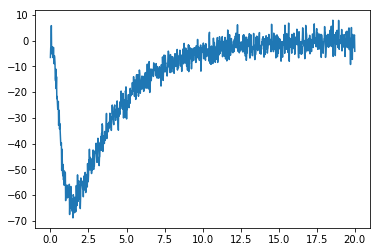

In [2]:
# Show the noisy data
plt.figure()
plt.plot(times, values)
plt.show()

In [3]:
# Combine the forward model and experimental data into an inference problem
problem = pints.SingleOutputProblem(model, times, values)

# Select one of PINTS' error measures, and run an optimisation to infer the parameters
error_measure = pints.SumOfSquaresError(problem)

initial_point = [1, 2, 3]

optimisation = pints.OptimisationController(
    error_measure, initial_point, method=pints.XNES)

optimisation.set_log_to_screen(False)

parameters, error = optimisation.run()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in power
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in multiply
/home/michael/dev/pints/pints/_error_measures.py:297: RuntimeWarning: overflow encountered in square
  return np.sum((np.sum(((self._problem.evaluate(x) - self._values)**2),


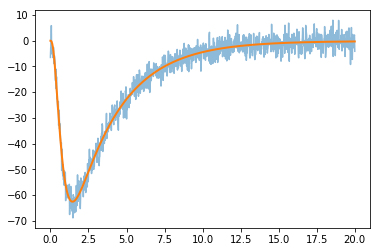

In [4]:
# Show the quality of fit

plt.figure()
plt.plot(times, values, alpha=0.5)
plt.plot(times, model.simulate(parameters, times), lw=2)
plt.show()

## Optimisation and sampling using a loglikelihood

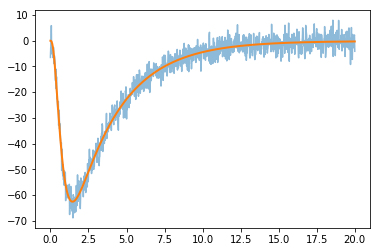

In [5]:
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, sigma=3)

optimisation = pints.OptimisationController(
    error_measure, initial_point, method=pints.XNES)
optimisation.set_log_to_screen(False)
parameters, error = optimisation.run()

plt.figure()
plt.plot(times, values, alpha=0.5)
plt.plot(times, model.simulate(parameters, times), lw=2)
plt.show()

In [6]:
# Set up a sampling routine with 3 MCMC chains, all starting from the same point
mcmc = pints.MCMCController(
    log_likelihood, 3, [initial_point]*3, method=pints.AdaptiveCovarianceMCMC)
mcmc.set_max_iterations(2000)
mcmc.set_log_to_screen(False)

samples = mcmc.run()

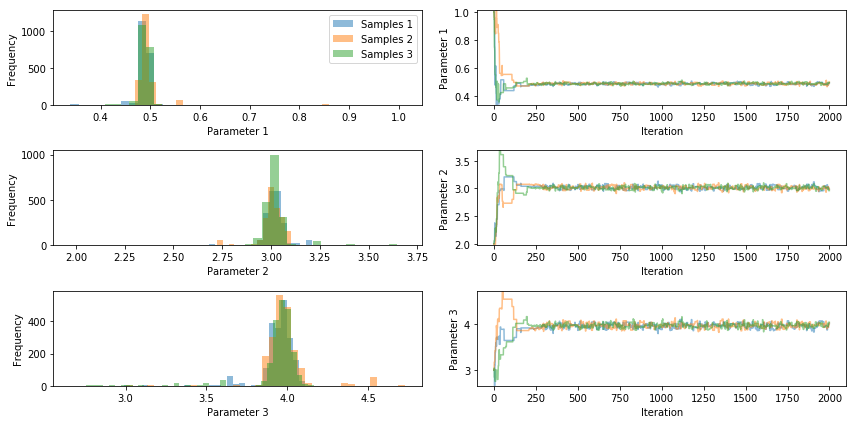

In [7]:
# Use a diagnostic plot to check if the chains have converged
import pints.plot
pints.plot.trace(samples)
plt.show()

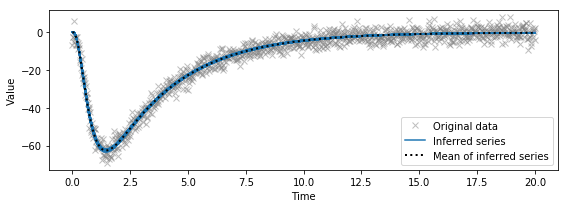

In [8]:
# Plot several predictions that are all likely sources of the experimental data
pints.plot.series(np.vstack(samples[:,1000:]), problem)
plt.show()

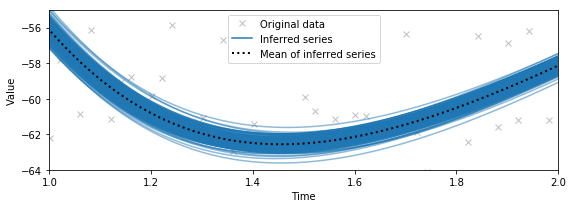

In [11]:
pints.plot.series(np.vstack(samples[:,1000:]), problem)
plt.xlim(1, 2)
plt.ylim(-64, -55)
plt.show()